# Task 2: Exploratory Data Analysis
Analyze the data to understand patterns and factors influencing financial inclusion in Ethiopia.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
# Load Data
data_path = "../data/raw/ethiopia_fi_unified_data.csv"
df = pd.read_csv(data_path)

# --- 1. Dataset Overview ---
print("--- Dataset Overview ---")
print(df.groupby(['record_type', 'pillar']).size())
print("\nUnique Indicators:\n", df['indicator'].unique())

--- Dataset Overview ---
record_type  pillar        
observation  Access            9
             Infrastructure    4
             Usage             3
target       Access            1
dtype: int64

Unique Indicators:
 ['Account Ownership' 'Mobile Money Account Ownership'
 'Made or received digital payment' 'Used account to receive wages'
 'Account Ownership (Men)' 'Account Ownership (Women)'
 'Account Ownership (Urban)' 'Account Ownership (Rural)'
 'Telebirr Users (Million)' 'M-Pesa Active Users (Million)'
 'Telebirr Launch' 'M-Pesa Ethiopia Launch' 'NFIS-II Strategy Launch'
 'Ethio Telecom Next Horizon Strategy'
 'Account Ownership Target (NFIS-II)' nan]


### Temporal Coverage

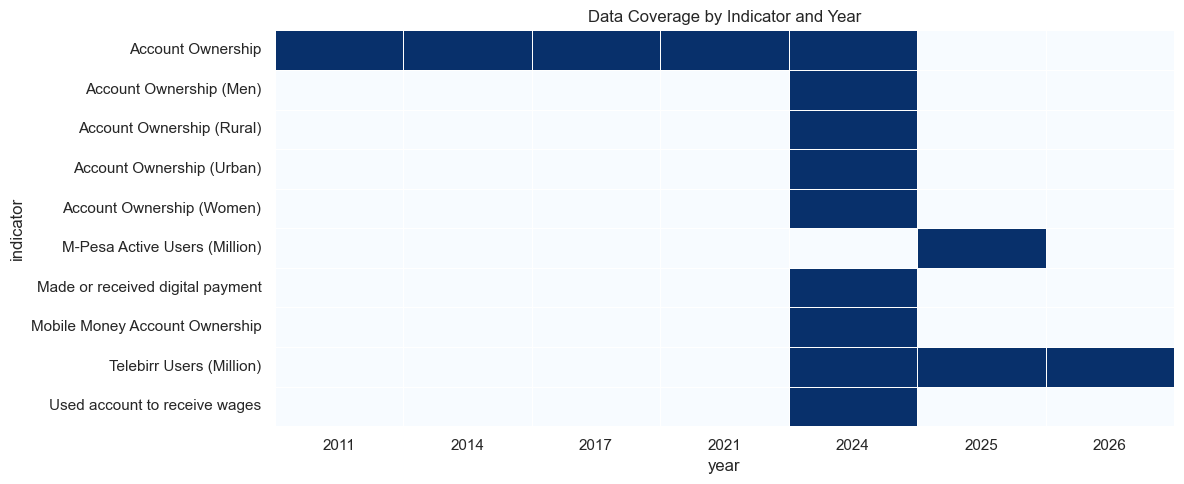

In [3]:
# Temporal Coverage
obs = df[df['record_type'] == 'observation'].copy()
obs['year'] = pd.to_datetime(obs['observation_date']).dt.year

plt.figure(figsize=(12, 5))
pivot_coverage = obs.pivot_table(index='indicator', columns='year', values='value_numeric', aggfunc='count')
sns.heatmap(pivot_coverage.fillna(0), cmap="Blues", cbar=False, linewidths=.5)
plt.title("Data Coverage by Indicator and Year")
plt.tight_layout()
plt.show()

### Access Analysis

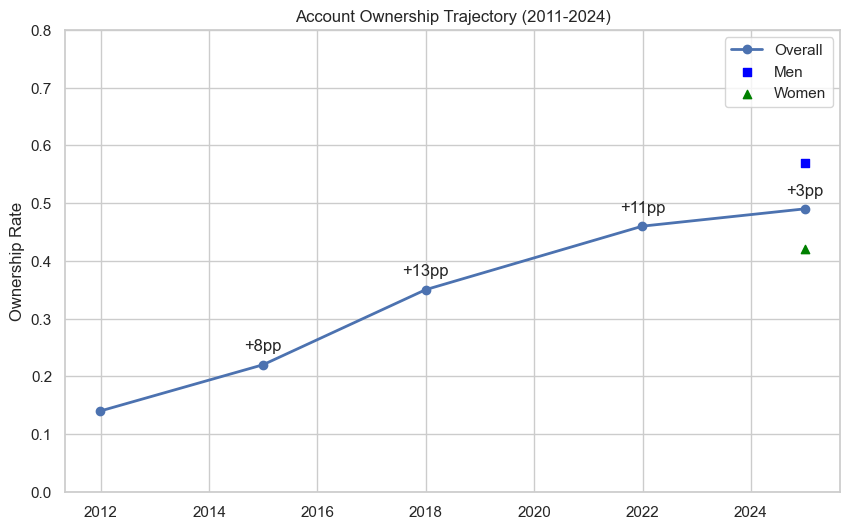

In [4]:
# Account Ownership Trajectory
acc = obs[obs['indicator_code'] == 'account_ownership'].sort_values('observation_date')
acc_men = obs[obs['indicator_code'] == 'account_ownership_men'].sort_values('observation_date')
acc_women = obs[obs['indicator_code'] == 'account_ownership_women'].sort_values('observation_date')

plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(acc['observation_date']), acc['value_numeric'], marker='o', linewidth=2, label='Overall')
if not acc_men.empty:
    plt.scatter(pd.to_datetime(acc_men['observation_date']), acc_men['value_numeric'], color='blue', marker='s', label='Men')
if not acc_women.empty:
    plt.scatter(pd.to_datetime(acc_women['observation_date']), acc_women['value_numeric'], color='green', marker='^', label='Women')

# Annotate Growth
for i in range(1, len(acc)):
    prev = acc.iloc[i-1]['value_numeric']
    curr = acc.iloc[i]['value_numeric']
    diff = curr - prev
    plt.annotate(f"+{diff*100:.0f}pp", 
                 (pd.to_datetime(acc.iloc[i]['observation_date']), curr),
                 xytext=(0, 10), textcoords='offset points', ha='center')

plt.title("Account Ownership Trajectory (2011-2024)")
plt.ylabel("Ownership Rate")
plt.ylim(0, 0.8)
plt.legend()
plt.show()

In [5]:
# Urban vs Rural Review
print("\n--- Urban vs Rural (Latest) ---")
print(obs[obs['indicator_code'].isin(['account_ownership_urban', 'account_ownership_rural'])][['indicator', 'value_numeric', 'observation_date']])


--- Urban vs Rural (Latest) ---
                    indicator  value_numeric observation_date
10  Account Ownership (Urban)          0.732       2024-12-31
11  Account Ownership (Rural)          0.433       2024-12-31


### Usage & Infrastructure

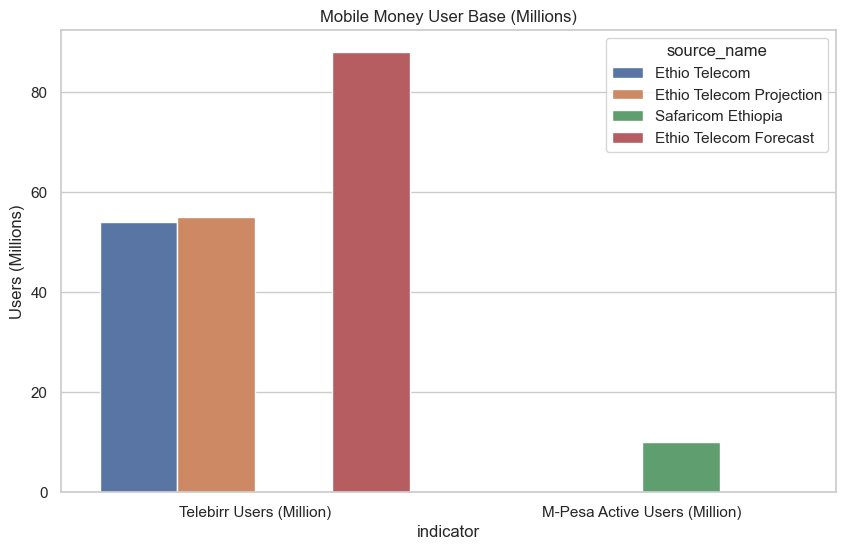

In [6]:
# Mobile Money & Telebirr
mm_users = obs[obs['indicator_code'].isin(['telebirr_users_m', 'mpesa_users_m'])].sort_values('observation_date')

plt.figure(figsize=(10, 6))
sns.barplot(data=mm_users, x='indicator', y='value_numeric', hue='source_name')
plt.title("Mobile Money User Base (Millions)")
plt.ylabel("Users (Millions)")
plt.show()

### Event Timeline

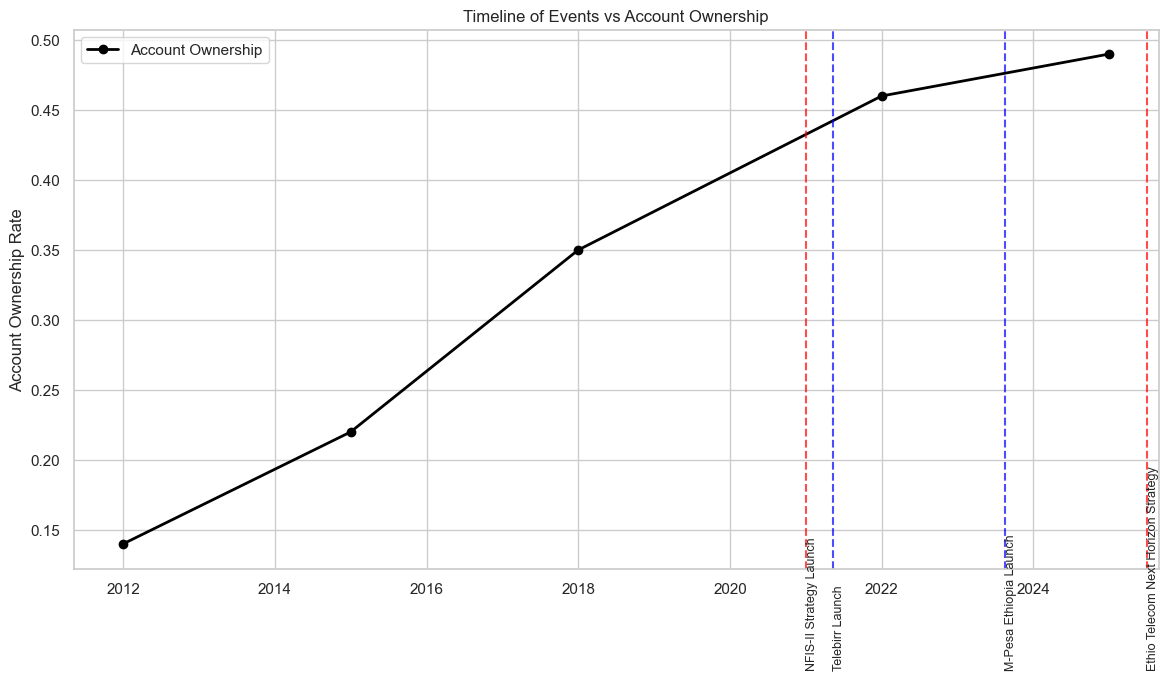

In [7]:
# Event Timeline Overlay
events = df[df['record_type'] == 'event'].sort_values('observation_date')

plt.figure(figsize=(14, 7))
# Plot Account Ownership again as base
plt.plot(pd.to_datetime(acc['observation_date']), acc['value_numeric'], marker='o', linewidth=2, color='black', label='Account Ownership')

# Overlay Events
colors = {'policy': 'red', 'product_launch': 'blue', 'infrastructure': 'green'}
for _, event in events.iterrows():
    ev_date = pd.to_datetime(event['observation_date'])
    plt.axvline(ev_date, color=colors.get(event['category'], 'gray'), linestyle='--', alpha=0.7)
    plt.text(ev_date, 0.05, event['indicator'], rotation=90, verticalalignment='bottom', fontsize=9)

plt.title("Timeline of Events vs Account Ownership")
plt.ylabel("Account Ownership Rate")
plt.legend(['Account Ownership'])
plt.show()